In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-crqs7t1e
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-crqs7t1e
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [2]:
!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'

In [3]:
!pip install ultralytics

In [4]:
!pip install pydantic==1.10.13

In [5]:
!mkdir /content/data
!cp /content/drive/MyDrive/DentalImages/ToothSegDataset/DentalPanoramicXrays.zip /content/data
!cp /content/drive/MyDrive/DentalImages/ToothSegDataset/Masks.zip /content/data

mkdir: cannot create directory ‘/content/data’: File exists


In [6]:
from segment_anything import sam_model_registry
sam_model = sam_model_registry['vit_b'](checkpoint='sam_vit_b_01ec64.pth')

<ipython-input-56-3eacbeff013a>:35: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  images = (images.resize((resize_shape), Image.ANTIALIAS))
<ipython-input-56-3eacbeff013a>:41: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img=img.resize((resize_shape), Image.ANTIALIAS)


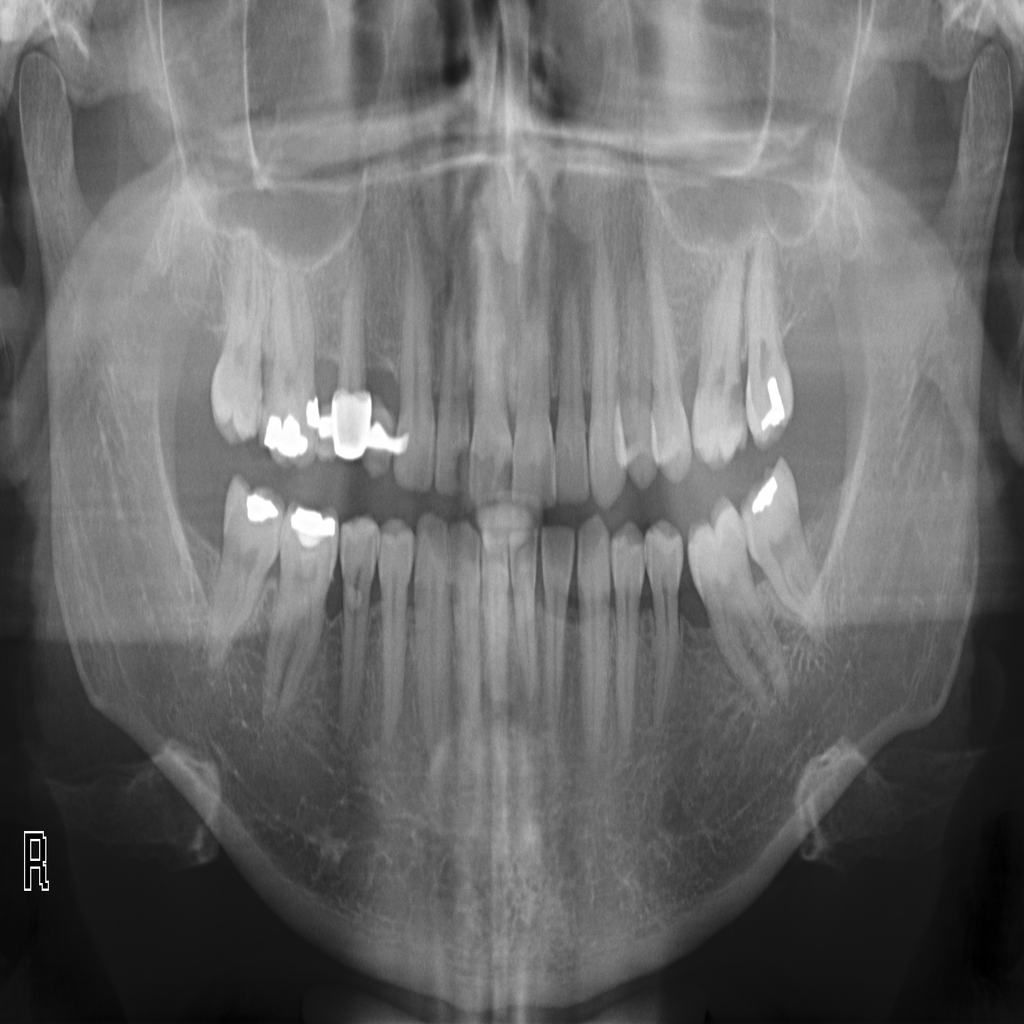

In [56]:
from ast import Pass
import cv2
import numpy as np
import os
import torch
from google.colab.patches import cv2_imshow
from PIL import Image
from zipfile import ZipFile
from natsort import natsorted

def convert_to_three_channel(img):
  if len(img.shape) > 2:
    pass
  else:
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  return img

def convert_to_one_channel(img):
  if len(img.shape) > 2:
    img = img[:,:,0]
  return img

def extract_image_paths(path, zip_name, folder_name, save_path):
  full_path = os.path.join(path, zip_name)
  ZipFile(full_path).extractall(save_path)
  unzipped_path = os.path.join(path, folder_name)
  dirs=natsorted(os.listdir(unzipped_path))
  return dirs

def load_images(resize_shape, path, zip_name, folder_name, save_path, convert_function):

    dirs = extract_image_paths(path, zip_name, folder_name, save_path)

    images=Image.open(os.path.join(path, folder_name, dirs[0]))
    images = (images.resize((resize_shape), Image.ANTIALIAS))
    images = convert_function(np.asarray(images))
    images = [images]

    for i in range(1,len(dirs)):
        img=Image.open(os.path.join(path, folder_name, dirs[i]))
        img=img.resize((resize_shape), Image.ANTIALIAS)

        img = convert_function(np.asarray(img))

        images.append(img)

    images = np.array(images)
    return images



PATH = "/content/data/"
X = load_images((1024, 1024), PATH, "DentalPanoramicXrays.zip",'Images/', "/content/data", convert_to_three_channel)
Y = load_images((1024, 1024), PATH, "Masks.zip", "Masks/", "/content/data/Masks", convert_to_one_channel)

x_train = X[:88]
x_val = X[88:]
y_train = Y[:88]
y_val = Y[88:]

cv2_imshow(x_train[3])






In [50]:
def get_fixed_coordinates(box, image):

  x_center = box[0].numpy()
  y_center = box[1].numpy()
  width = box[2].numpy()
  height = box[3].numpy()

  x_center *= image.shape[1]
  y_center *= image.shape[0]
  width *= image.shape[1]
  height *= image.shape[0]

  x1 = int(x_center - width / 2)
  y1 = int(y_center - height / 2)
  x2 = int(x_center + width / 2)
  y2 = int(y_center + height / 2)

  return x1, y1, x2, y2


In [18]:
from ultralytics import YOLO
from torch.nn.functional import threshold, normalize
from tqdm import tqdm
import random
import gc
import torch

optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters())
loss_fn = torch.nn.MSELoss()

gc.collect()
torch.cuda.empty_cache()


yolo_model = YOLO("/content/drive/MyDrive/DentalImages/TrainingCheckpoints/best_yolov8.pt")
EPOCHS = 2
MODEL_SAVE_PATH = '/content/SAM'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam_model.to(device)
yolo_model.to(device)

#Training loop

for _ in tqdm(range(EPOCHS)):
  random_select = random.randint(0,88)

  #The weird indexing is meant to add the batch dimension
  image = x_train[random_select:random_select+1]
  gt_mask = y_train[random_select:random_select+1]

  image = image.astype(np.float32)
  image /= 255.0
  image = torch.from_numpy(image)

  image = image.to(device)


  with torch.no_grad():
    image_embedding = sam_model.image_encoder(image)
    results = yolo_model.predict(image)

    boxes = results[0].boxes.xywhn
    boxes = torch.Tensor.cpu(boxes)
    box_list = []

    for box in boxes:
      x1, y1, x2, y2 = get_fixed_coordinates(box,image)
      box_list.append([x1, y1, x2, y2])
    box_tensor = torch.tensor(box_list)

    box_tensor = box_tensor.to(device)
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
              points=None,
              boxes=box_tensor,
              masks=None,
          )

  low_res_masks, iou_predictions = sam_model.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=sam_model.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False,
  )



  upscaled_masks = sam_model.postprocess_masks(low_res_masks, (1024,1024),(1024,1024)).to("cpu")

  binary_mask = normalize(threshold(upscaled_masks, 0.0, 0)).to("cpu")
  gt_mask = gt_mask.astype(np.float32)
  gt_mask /= 255.0
  gt_mask = torch.from_numpy(np.stack([gt_mask]*binary_mask.shape[0], axis=0))


  loss = loss_fn(binary_mask, gt_mask)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  print(loss.item())
torch.save(sam_model, MODEL_SAVE_PATH)

  0%|          | 0/2 [00:00<?, ?it/s]


0: 1024x1024 35 tooths, 16.5ms
Speed: 0.0ms preprocess, 16.5ms inference, 4.3ms postprocess per image at shape (1, 3, 1024, 1024)


 50%|█████     | 1/2 [00:07<00:07,  7.05s/it]

0.17730894684791565

0: 1024x1024 32 tooths, 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 3.3ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 2/2 [00:14<00:00,  7.37s/it]

0.18669837713241577


(3, 1024, 1024)


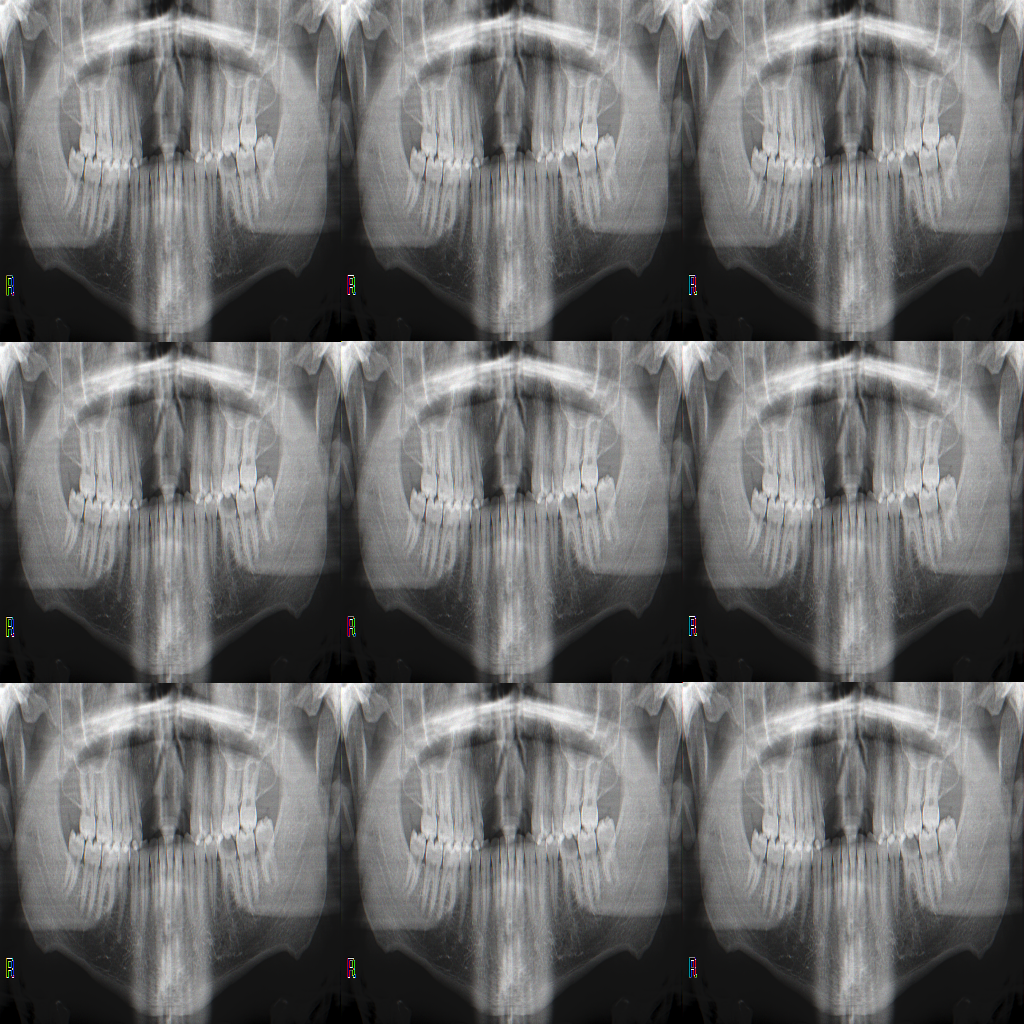

In [29]:
from segment_anything import SamAutomaticMaskGenerator
from google.colab.patches import cv2_imshow
loaded_model = torch.load(MODEL_SAVE_PATH)

mask_generator = SamAutomaticMaskGenerator(loaded_model)

image = X[0,:,:,:]
print(image.shape)
image = image.reshape((1024,1024,3))
result_image = mask_generator.generate(image)[0]['segmentation']
cv2_imshow(image)

(1150, 2900, 3)

image 1/28 /content/YOLO_dataset/images/val/100.png: 256x640 32 tooths, 379.4ms
image 2/28 /content/YOLO_dataset/images/val/101.png: 288x640 30 tooths, 172.8ms
image 3/28 /content/YOLO_dataset/images/val/102.png: 288x640 24 tooths, 177.7ms
image 4/28 /content/YOLO_dataset/images/val/103.png: 288x640 23 tooths, 173.5ms
image 5/28 /content/YOLO_dataset/images/val/104.png: 288x640 26 tooths, 184.1ms
image 6/28 /content/YOLO_dataset/images/val/105.png: 288x640 28 tooths, 180.1ms
image 7/28 /content/YOLO_dataset/images/val/106.png: 256x640 30 tooths, 169.3ms
image 8/28 /content/YOLO_dataset/images/val/107.png: 288x640 30 tooths, 165.6ms
image 9/28 /content/YOLO_dataset/images/val/108.png: 288x640 21 tooths, 173.0ms
image 10/28 /content/YOLO_dataset/images/val/109.png: 288x640 31 tooths, 193.3ms
image 11/28 /content/YOLO_dataset/images/val/110.png: 288x640 25 tooths, 183.6ms
image 12/28 /content/YOLO_dataset/images/val/111.png: 288x640 29 tooths, 194.6ms
image 13/28 /content

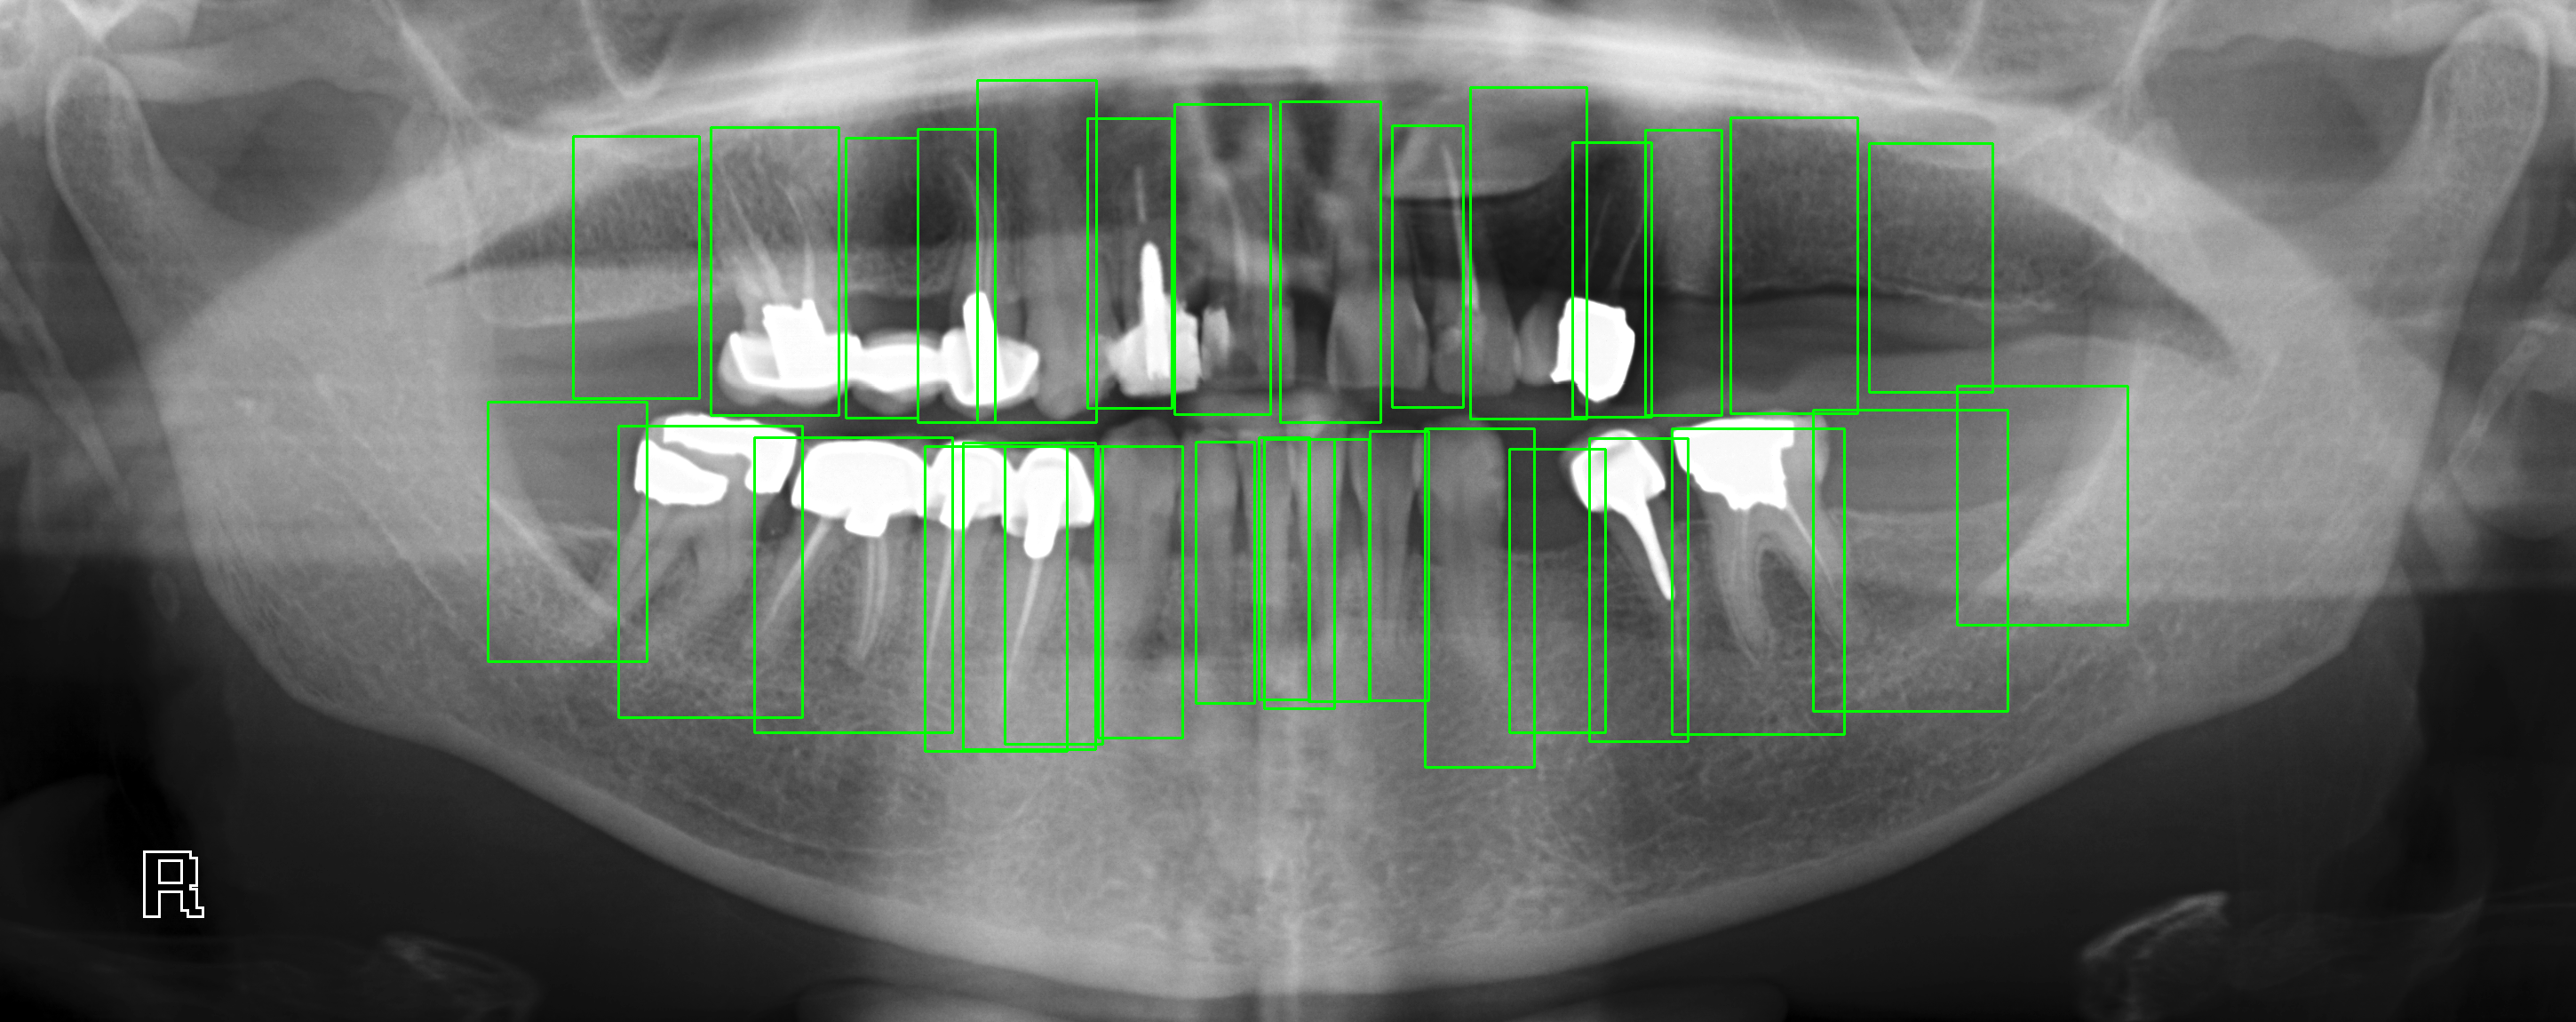

In [ ]:
image = cv2.imread("/content/YOLO_dataset/images/val/90.png")
print(image.shape)
# image = cv2.resize(image, (1024,1024))
results = model.predict("/content/YOLO_dataset/images/val/")
boxes = results[0].boxes.xywhn
print(len(results))
for box in boxes:
  # print(box)
  # x1 = int(np.floor(box[0]).numpy())
  # y1 = int(np.floor(box[1]).numpy())
  # x2 = int(np.floor(box[2]).numpy())
  # y2 = int(np.floor(box[2]).numpy())

  x_center = box[0].numpy()
  y_center = box[1].numpy()
  width = box[2].numpy()
  height = box[3].numpy()

  x_center *= image.shape[1]
  y_center *= image.shape[0]
  width *= image.shape[1]
  height *= image.shape[0]

  x1 = int(x_center - width / 2)
  y1 = int(y_center - height / 2)
  x2 = int(x_center + width / 2)
  y2 = int(y_center + height / 2)
  print(x1,y1,x2,y2)

  cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
cv2_imshow(image)